In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
import matplotlib
matplotlib.rcParams['font.size'] = 8
from phoebe.dependencies import distl
import phoebe
from astropy import units as u
from astropy import constants as c
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

In [2]:
#values from the ELLC solution and derived quantities
ellc_res = {
    'period@binary': phoebe.gaussian(51.41888, 0.00008),
    't0_supconj': phoebe.gaussian(2458696.0199, 0.0002),
    'requivsumfrac': phoebe.gaussian(0.0705, 0.00045),
    'requivratio': phoebe.gaussian(0.47, 0.01),
    'incl@binary': phoebe.gaussian(86.35, 0.04),
    'sbratio': phoebe.gaussian(1.03,0.035),
    'ecc': phoebe.gaussian(0.4242, 0.0003),
    'per0': phoebe.gaussian(0.3718*180/np.pi,0.0023*180/np.pi),
    'sma@primary': phoebe.gaussian(44.564,0.1055),
    'ld_coeffs[0]@primary': phoebe.gaussian(0.2,0.1),
    'ld_coeffs[1]@primary': phoebe.gaussian(0.5,0.3),
    'ld_coeffs[0]@secondary': phoebe.gaussian(0.2,0.15),
    'ld_coeffs[1]@secondary': phoebe.gaussian(0.5,0.3),
    'vsini@primary': phoebe.gaussian(27.6,0.45),
    'vgamma_1': phoebe.gaussian(-11.68,0.03),
    'vgamma': phoebe.gaussian(-13.5,0.1),
    'semi_amplitude': phoebe.gaussian(47.74,0.06),
    'mass_function': phoebe.gaussian(0.438,0.002),
    'mass@primary': phoebe.gaussian(3.45,0.12),
    'requiv@primary': phoebe.gaussian(5.14,0.135),
    'teff@primary': phoebe.gaussian(9975,125),
    'logg@primary': phoebe.gaussian(3.63,0.20),
    'parallax': phoebe.gaussian(12.18,0.31),
    'logL@system': phoebe.gaussian(2.385,0.025),
    'r1': phoebe.gaussian(0.0479,0.00025),
    'r2': phoebe.gaussian(0.0226,0.0005),
    'teffratio': phoebe.gaussian(1.02,0.05),
    'syncpar@primary': phoebe.gaussian(5.45,0.50),
    'syncpar@secondary': phoebe.gaussian(50,10),
    'q@binary': phoebe.gaussian(0.588,0.018),
    'esinw': phoebe.gaussian(0.1541, 0.0009),
    'ecosw': phoebe.gaussian(0.3952, 0.0005)

}

All available data:

In [3]:
lc_tess_old = np.loadtxt('data/photometry/tess_corrected.txt') # detrending with periastron brightening
lc_tess = np.loadtxt('data/photometry/tess_corrected_new.txt') # flat out-of-eclipse detrending
rv1_song = np.loadtxt('data/RV/SONG_LSD.txt')
rv1_bischoff = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt')
# adjust all times to BJD
lc_tess[:,0] = lc_tess[:,0]+2457000 
lc_tess_old[:,0] = lc_tess_old[:,0]+2457000
rv1_song[:,0]=rv1_song[:,0]+2400000
rv1_bischoff[:,0]=rv1_bischoff[:,0]+2457000

Setup the PHOEBE bundle and all relevant parameters to compute a forward model with the ELLC backend and spherical geometry, to make sure that we still get a similar result as using pure ELLC (not interfacing with PHOEBE):

In [4]:
b = phoebe.default_binary()
b.add_dataset('lc', times=lc_tess[:,0], fluxes=lc_tess[:,1], sigmas=lc_tess[:,2], 
              compute_phases=phoebe.linspace(-0.5,0.5,1000),
              passband='TESS:T')
b.add_dataset('lc', times=lc_tess_old[:,0], fluxes=lc_tess_old[:,1], sigmas=lc_tess_old[:,2],
              compute_phases=phoebe.linspace(-0.5,0.5,1000),
              passband='TESS:T')
# b.add_dataset('rv', component='primary', times=rv1_song[:,0], rvs=rv1_song[:,1], sigmas=rv1_song[:,2])
# b.add_dataset('rv', component='primary', times=rv1_bischoff[:,0], rvs=rv1_bischoff[:,1], sigmas=rv1_bischoff[:,2])

<ParameterSet: 45 parameters | contexts: figure, compute, dataset, constraint>

In [5]:
# b.add_compute('ellc')
# b.set_value_all('ld_mode', value='manual')
# b.set_value_all('ld_func', value='square_root')
# b.set_value_all('rv_method', compute='ellc01', value='flux-weighted')
# b.set_value_all('irrad_method', compute='ellc01', value='none')

In [6]:
b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')

b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

In [7]:
b.flip_constraint('sma@primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {sma@primary@component} * ((1.000000 / {q@binary@component}) + 1.000000) (solar units) => 5.3 solRad>

In [8]:
b.set_value_all('gravb_bol', 1.0)
b.set_value_all('irrad_frac_refl_bol', 1.0)
b.set_value_all('pblum_mode', 'dataset-scaled')

Set all relevant values in the bundle:

In [9]:
ph_params = ['t0_supconj', 'period@binary', 'requivsumfrac', 'requivratio', 
             'incl@binary', 'esinw', 'ecosw', 'teff@primary', 'teffratio', 'q@binary',
             'sma@primary', 'vgamma', 'syncpar@primary', 'syncpar@secondary']
for twig in ph_params:
    b.set_value(twig, ellc_res[twig].loc)
    
# b.set_value_all('ld_coeffs@primary', [0.2,0.5])
# b.set_value_all('ld_coeffs@secondary', [0.2,0.5])

Compute with 'sphere' and 'roche' distortions:

In [10]:
b.add_server('remoteslurm', crimpl_name='terra',
             use_conda=True, 
             conda_env='phoebe-devel', nprocs=96, walltime=48, install_deps=False,
             server='terra_phoebe_compute')

<ParameterSet: 11 parameters | qualifiers: walltime, install_deps, conda_env, crimpl_name, nprocs, mail_user, mail_type, use_mpi, slurm_job_name, isolate_env, use_conda>

In [13]:
b.set_value('ntriangles', component='secondary', value=20000)
b.set_value('ntriangles', component='primary', value=20000)

In [14]:
b.set_value('distortion_method', component='secondary', value='sphere')
b.set_value('distortion_method', component='primary', value='sphere')
b.set_value_all('irrad_method', 'none')
b.enable_dataset('lc01')
b.disable_dataset('lc02')
b.run_checks()
b.run_delayed_constraints()
b.run_compute('phoebe01', model='sphere', irrad_method='none', use_server='terra_phoebe_compute')

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/angela/crimpl/crimpl-job-2021.06.29-09.20.14/*"
# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.06.29-09.20.14/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /home/users/angela/crimpl/crimpl-job-2021.06.29-09.20.14"
# crimpl: scp crimpl_submit_script.sh /Users/angela/Documents/WORK/PHOETTING/adra-paper/_gSkslnOrhOBRVIELThxlqAkcexMxrD.py terra:/home/users/angela/crimpl/crimpl-job-2021.06.29-09.20.14/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; echo '_gSkslnOrhOBRVIELThxlqAkcexMxrD.py' >> /home/users/angela/crimpl/crimpl-job-2021.06.29-09.20.14/crimpl-input-files.list"
# cri

<ParameterSet: 4 parameters | qualifiers: comments, times, fluxes, flux_scale>

In [15]:
b.set_value('distortion_method', component='secondary', value='sphere')
b.set_value('distortion_method', component='primary', value='roche')
b.set_value_all('irrad_method', 'horvat')
b.enable_dataset('lc02')
b.disable_dataset('lc01')
b.run_checks()
b.run_delayed_constraints()
b.run_compute('phoebe01', model='roche', use_server='terra_phoebe_compute')

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/angela/crimpl/crimpl-job-2021.06.29-09.24.10/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.06.29-09.24.10/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /home/users/angela/crimpl/crimpl-job-2021.06.29-09.24.10"
# crimpl: scp crimpl_submit_script.sh /Users/angela/Documents/WORK/PHOETTING/adra-paper/_CFihdeihlzYinUdjwCYgKOFoddsDYQ.py terra:/home/users/angela/crimpl/crimpl-job-2021.06.29-09.24.10/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; echo '_CFihdeihlzYinUdjwCYgKOFoddsDYQ.py' >> /home/users/angela/crimpl/crimpl-job-2021.06.29-09.24.10/crimpl-input-files.list"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; echo 'phoebe-devel' > /home/users/ang

<ParameterSet: 4 parameters | qualifiers: comments, times, fluxes, flux_scale>

In [16]:
b.save('periastron_model.bundle')

'periastron_model.bundle'

In [17]:
times_obs = b.get_value('times', context='dataset', dataset='lc02')
times_model = b.get_value('times', context='model', model='roche', dataset='lc02')

phases_obs = b.to_phase(times_obs)
phases_model = b.to_phase(times_model)

sobs = np.argsort(phases_obs)
smodel = np.argsort(phases_model)

fluxes_flat = b.get_value('fluxes', context='dataset', dataset='lc01')
fluxes_per0 = b.get_value('fluxes', context='dataset', dataset='lc02')

fluxes_sphere = b.get_value('fluxes', context='model', model='sphere', dataset='lc01')
fluxes_roche = b.get_value('fluxes', context='model', model='roche', dataset='lc02')

<ipython-input-18-0c8a9caf2e7c>:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('plots/' + 'periastron_phoebe.pdf', dpi=300, rasterized=True)
<ipython-input-18-0c8a9caf2e7c>:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('plots/' + 'periastron_phoebe.png', dpi=300, rasterized=True)


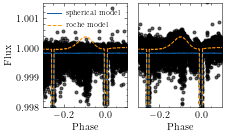

In [18]:
%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=[10/3, 2.0941842916664606])
# b.plot(kind='lc', dataset='lc01', model=['sphere', 'roche'], x='phases', y='fluxes', 
#            s={'dataset': 0.0025, 'model': 0.025}, ylim=((0.998,1.001)),
#            marker={'dataset': '.'}, ax=axes[0], draw=True)
# b.plot(kind='lc', dataset='lc02', model=['sphere', 'roche'], x='phases', y='fluxes', 
#            s={'dataset': 0.0025, 'model': 0.025}, ylim=((0.998,1.001)),
#            marker={'dataset': '.'}, ax=axes[1], draw=True)

ax = axes[0]
ax.plot(phases_obs[sobs], fluxes_flat[sobs], '.k', alpha=0.6, rasterized=True)
ax.plot(phases_model[smodel], fluxes_sphere[smodel], c='C0', ls='-', lw=1, label='spherical model')
ax.plot(phases_model[smodel], fluxes_roche[smodel], c='C2', lw=1, ls='--', label='roche model')
ax.legend(fontsize=7)

ax = axes[1]
ax.plot(phases_obs[sobs], fluxes_per0[sobs], '.k', alpha=0.6, rasterized=True)
ax.plot(phases_model[smodel], fluxes_sphere[smodel], c='C0', ls='-', lw=1, label='spherical model')
ax.plot(phases_model[smodel], fluxes_roche[smodel], c='C2', lw=1, ls='--', label='roche model')
# ax.legend(fontsize=7)

axes[0].set(xlim=[-0.3, 0.1], ylim=[0.998,1.0015], ylabel='Flux', xlabel='Phase')
axes[1].set(xlim=[-0.3, 0.1], ylim=[0.998,1.0015], yticks=[], xlabel='Phase', ylabel='')

plt.subplots_adjust(hspace=0.05, wspace=0.05)
fig.tight_layout()
fig.savefig('plots/' + 'periastron_phoebe.pdf', dpi=300, rasterized=True)
fig.savefig('plots/' + 'periastron_phoebe.png', dpi=300, rasterized=True)
plt.show()